In [1]:
import cv2
import util
import json
import os
import matplotlib.pyplot as plt
from car_detectors import YOLOv3CarDetector

In [50]:
def track_cars_with_gt(car_detector, folder, img_id):
    """
    Track cars that are ONLY marked in the ground truth annotation. Generate:
    1. an annotated video clip, 
    2. an annotation file containing gt velocity and position, and predicted bboxes for all 40 frames,
    3. the annotated ground truth image for reference.
    """
    # load ground truth annotation
    path_annotation = f'dataset/velocity/{folder}/clips/{img_id}/annotation.json'
    with open(path_annotation) as file:
        # parse json file
        gt_annotation = json.load(file)
    
    # create output folder
    newpath = f'dataset/velocity/custom/{img_id}'
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    
    # detect all cars in the image
    temp_annotations = []
    for i in range(40):
        img = util.read_velocity_image(folder, img_id, frame=i+1, annotation=False)
        annotation = car_detector.predict(img)
        temp_annotations.append(annotation)
        
    # keep only the cars that are marked in the gt annotation
    out_annotations = [{} for _ in range(len(gt_annotation))]
    missing_count = 0
    for i in range(len(gt_annotation)): # iterate all bounding boxes in the ground truth annotation
        out_annotations[i]['velocity'] = gt_annotation[i]['velocity']
        out_annotations[i]['position'] = gt_annotation[i]['position']
        out_annotations[i]['frames'] = [{'frame':k+1} for k in range(40)]
        
        bbox = gt_annotation[i]['bbox']
        bbox1 = (bbox['left'], bbox['top'], bbox['right'], bbox['bottom'])
        
        for j in range(39, -1, -1):
            max_iou = 0
            max_bbox = None
            for a in temp_annotations[j]:
                bbox2 = (a['bbox']['left'], a['bbox']['top'], a['bbox']['right'], a['bbox']['bottom'])
                iou = util.IoU(bbox1, bbox2)
                if iou > max(max_iou, 0.3):
                    max_iou = iou
                    max_bbox = a['bbox']
            if max_iou > 0:
                out_annotations[i]['frames'][j]['bbox'] = max_bbox
                bbox1 = (max_bbox['left'], max_bbox['top'], max_bbox['right'], max_bbox['bottom'])
            else:
                missing_count += 1
    
    # fill empty bbox
    #if missing_count < 20 * len(out_annotations):
    """
    for i in range(len(out_annotations)):
        non_missing = [1 if 'bbox' in out_annotations[i]['frames'][j].keys() else 0 for j in range(40)]
        index_non_missing = [-1] + [i for i, x in enumerate(non_missing) if x == 1] + [40]
        for j in range(len(index_non_missing) - 1):
            idx_prev, idx_next = index_non_missing[j], index_non_missing[j + 1]
            n = idx_next - idx_prev - 1
            if n == 0:
                continue
            bbox_prev = out_annotations[i]['frames'][idx_prev]['bbox'] if idx_prev > -1 else out_annotations[i]['frames'][idx_next]['bbox']
            bbox_next = out_annotations[i]['frames'][idx_next]['bbox'] if idx_next < 40 else out_annotations[i]['frames'][idx_prev]['bbox']
            bbox_value_prev = [bbox_prev['left'],bbox_prev['top'],bbox_prev['right'],bbox_prev['bottom']]
            bbox_value_next = [bbox_next['left'],bbox_next['top'],bbox_next['right'],bbox_next['bottom']]
            diff = [(x - y) / (n + 1) for x, y in zip(bbox_value_next, bbox_value_prev)]
            
            for k in range(n):
                bbox_fill = [x + y for x, y in zip(bbox_value_prev, diff)]
                out_annotations[i]['frames'][idx_prev+k+1]['bbox'] = {
                    "top": int(bbox_fill[1]),
                    "right": int(bbox_fill[2]),
                    "bottom": int(bbox_fill[3]),
                    "left": int(bbox_fill[0])
                }
                bbox_value_prev = bbox_fill
    """
    # write annotations into json file
    with open(f'{newpath}/annotation.json', 'w', encoding='utf-8') as f:
        json.dump(out_annotations, f, ensure_ascii=False, indent=4)
    
    # write into video clip
    video = cv2.VideoWriter(f'{newpath}/output.avi', cv2.VideoWriter_fourcc('M','J','P','G'), 20, (1280, 720))
    for i in range(40):
        img = util.read_velocity_image(folder, img_id, frame=i+1, annotation=False)
        annotations = []
        for j in range(len(out_annotations)):
            if 'bbox' in out_annotations[j]['frames'][i]:
                annotations.append({'bbox':out_annotations[j]['frames'][i]['bbox']})
        #annotations = [{'bbox':out_annotations[j]['frames'][i]['bbox']} for j in range(len(out_annotations))]
        annotated_img = util.draw_annotation(img, annotations)
        video.write(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
    video.release()
    
    # add the annotated gt image for reference
    gt_img = util.read_velocity_image(folder, img_id, frame=40, annotation=True)
    cv2.imwrite(f'{newpath}/gt.jpg', cv2.cvtColor(gt_img, cv2.COLOR_BGR2RGB))
    

    print(f'id:{img_id} has {missing_count} missing predictions.')
    return missing_count

In [3]:
car_detector = YOLOv3CarDetector()

In [51]:
img_id = 24
folder = 'train'
track_cars_with_gt(car_detector, folder, img_id)

id:24 has 35 missing predictions.


35

In [20]:
folder = 'train'

for img_id in range(1, 1075):
    missing = track_cars_with_gt(car_detector, folder, img_id)
        

id:1 has 0 missing predictions.
id:2 has 0 missing predictions.
id:3 has 18 missing predictions.
id:4 has 0 missing predictions.
id:5 has 0 missing predictions.
id:6 has 11 missing predictions.
id:7 has 34 missing predictions.
id:8 has 0 missing predictions.
id:9 has 1 missing predictions.
id:10 has 0 missing predictions.
id:11 has 0 missing predictions.
id:12 has 21 missing predictions.
id:13 has 0 missing predictions.
id:14 has 4 missing predictions.
id:15 has 0 missing predictions.
id:16 has 0 missing predictions.
id:17 has 0 missing predictions.
id:18 has 0 missing predictions.
id:19 has 30 missing predictions.
id:20 has 0 missing predictions.
id:21 has 19 missing predictions.
id:22 has 0 missing predictions.
id:23 has 0 missing predictions.
id:24 has 35 missing predictions.
id:25 has 0 missing predictions.
id:26 has 0 missing predictions.
id:27 has 0 missing predictions.
id:28 has 3 missing predictions.
id:29 has 2 missing predictions.
id:30 has 0 missing predictions.
id:31 has 0 

id:245 has 2 missing predictions.
id:246 has 0 missing predictions.
id:247 has 0 missing predictions.
id:248 has 0 missing predictions.
id:249 has 0 missing predictions.
id:250 has 0 missing predictions.
id:251 has 0 missing predictions.
id:252 has 0 missing predictions.
id:253 has 34 missing predictions.
id:254 has 0 missing predictions.
id:255 has 0 missing predictions.
id:256 has 0 missing predictions.
id:257 has 0 missing predictions.
id:258 has 0 missing predictions.
id:259 has 20 missing predictions.
id:260 has 1 missing predictions.
id:261 has 21 missing predictions.
id:262 has 0 missing predictions.
id:263 has 32 missing predictions.
id:264 has 0 missing predictions.
id:265 has 10 missing predictions.
id:266 has 0 missing predictions.
id:267 has 0 missing predictions.
id:268 has 0 missing predictions.
id:269 has 0 missing predictions.
id:270 has 0 missing predictions.
id:271 has 1 missing predictions.
id:272 has 0 missing predictions.
id:273 has 0 missing predictions.
id:274 ha

id:486 has 0 missing predictions.
id:487 has 0 missing predictions.
id:488 has 0 missing predictions.
id:489 has 0 missing predictions.
id:490 has 0 missing predictions.
id:491 has 0 missing predictions.
id:492 has 0 missing predictions.
id:493 has 0 missing predictions.
id:494 has 0 missing predictions.
id:495 has 0 missing predictions.
id:496 has 28 missing predictions.
id:497 has 32 missing predictions.
id:498 has 0 missing predictions.
id:499 has 0 missing predictions.
id:500 has 0 missing predictions.
id:501 has 0 missing predictions.
id:502 has 2 missing predictions.
id:503 has 22 missing predictions.
id:504 has 0 missing predictions.
id:505 has 0 missing predictions.
id:506 has 4 missing predictions.
id:507 has 0 missing predictions.
id:508 has 0 missing predictions.
id:509 has 0 missing predictions.
id:510 has 0 missing predictions.
id:511 has 2 missing predictions.
id:512 has 0 missing predictions.
id:513 has 0 missing predictions.
id:514 has 0 missing predictions.
id:515 has 

id:727 has 14 missing predictions.
id:728 has 0 missing predictions.
id:729 has 3 missing predictions.
id:730 has 0 missing predictions.
id:731 has 0 missing predictions.
id:732 has 0 missing predictions.
id:733 has 0 missing predictions.
id:734 has 0 missing predictions.
id:735 has 0 missing predictions.
id:736 has 0 missing predictions.
id:737 has 0 missing predictions.
id:738 has 0 missing predictions.
id:739 has 0 missing predictions.
id:740 has 0 missing predictions.
id:741 has 1 missing predictions.
id:742 has 19 missing predictions.
id:743 has 0 missing predictions.
id:744 has 0 missing predictions.
id:745 has 0 missing predictions.
id:746 has 0 missing predictions.
id:747 has 0 missing predictions.
id:748 has 40 missing predictions.
id:749 has 1 missing predictions.
id:750 has 0 missing predictions.
id:751 has 0 missing predictions.
id:752 has 0 missing predictions.
id:753 has 2 missing predictions.
id:754 has 0 missing predictions.
id:755 has 18 missing predictions.
id:756 has

id:967 has 0 missing predictions.
id:968 has 5 missing predictions.
id:969 has 0 missing predictions.
id:970 has 1 missing predictions.
id:971 has 12 missing predictions.
id:972 has 0 missing predictions.
id:973 has 0 missing predictions.
id:974 has 0 missing predictions.
id:975 has 0 missing predictions.
id:976 has 0 missing predictions.
id:977 has 4 missing predictions.
id:978 has 0 missing predictions.
id:979 has 0 missing predictions.
id:980 has 0 missing predictions.
id:981 has 0 missing predictions.
id:982 has 0 missing predictions.
id:983 has 0 missing predictions.
id:984 has 1 missing predictions.
id:985 has 0 missing predictions.
id:986 has 0 missing predictions.
id:987 has 0 missing predictions.
id:988 has 0 missing predictions.
id:989 has 0 missing predictions.
id:990 has 0 missing predictions.
id:991 has 16 missing predictions.
id:992 has 0 missing predictions.
id:993 has 0 missing predictions.
id:994 has 0 missing predictions.
id:995 has 0 missing predictions.
id:996 has 1

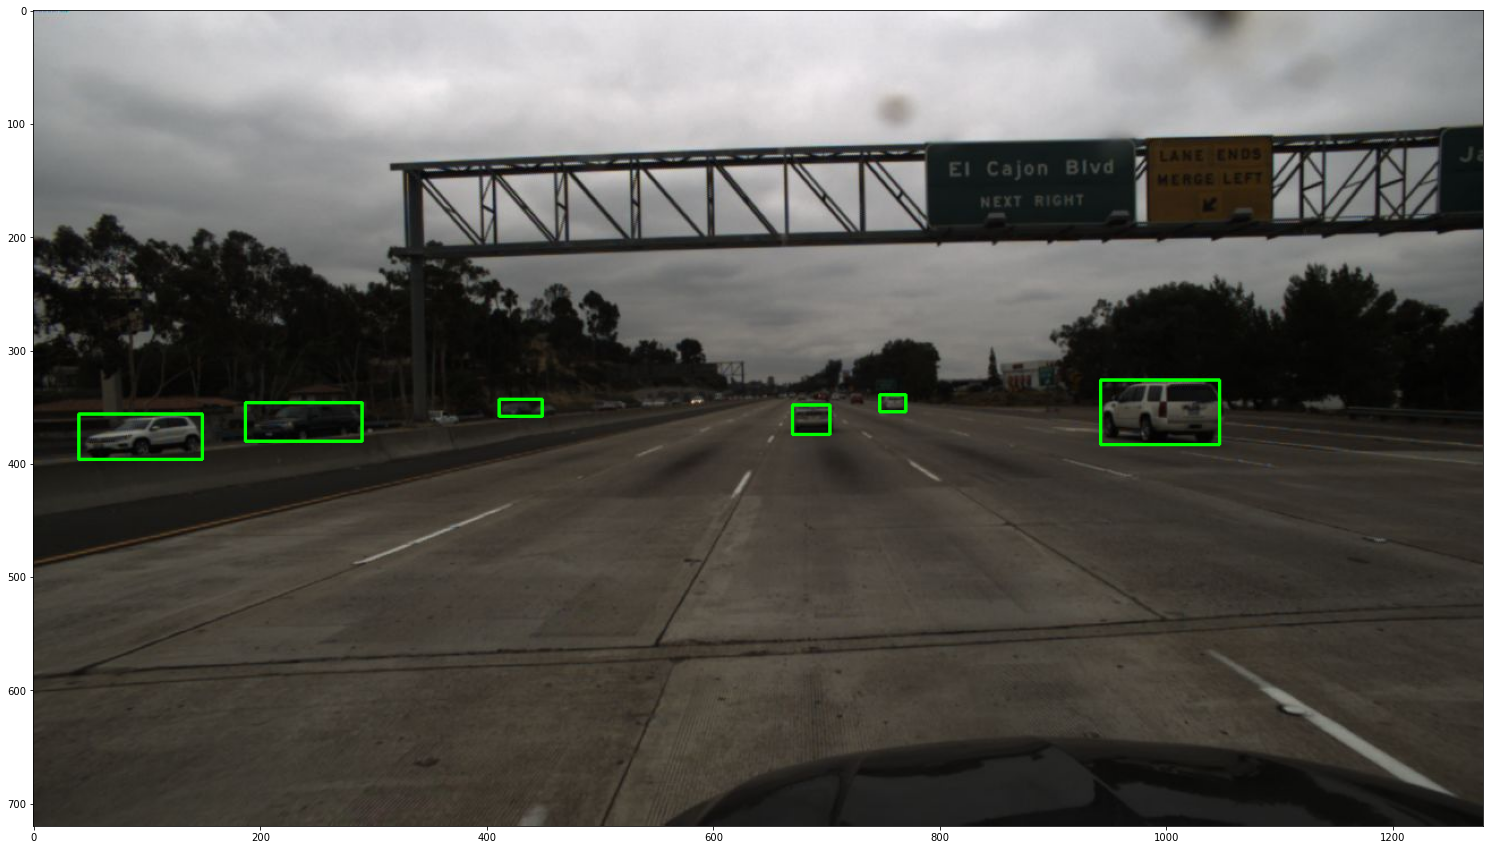

In [22]:
img = util.read_velocity_image('train', 1072, frame=13, annotation=False)
annotation = car_detector.predict(img)
annotated_img = util.draw_annotation(img, annotation)
fig = plt.figure(figsize=(30,15))
plt.imshow(annotated_img)

In [14]:
with open('dataset/velocity/custom/6/annotation.json') as f:
    a = json.load(f)
missing = [1 if 'bbox' in a[0]['frames'][j].keys() else 0 for j in range(40)]